# Flexible representation of quantum images - [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf)

## Representation equation $| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle$, where

$\theta_i$ - continuous representation of the inensity,

$i$ - binary expansion of the pixel coordinate.

Step 0: dependencies import

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math

Step 1: image generation

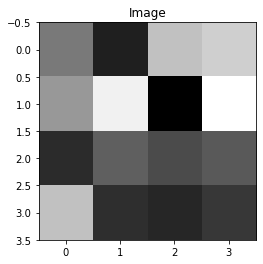

In [2]:
image = np.random.uniform(low=0, high=255, size=(4,4)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

Step 2: flattening image into vector (for convenience). Calculation of sufficient nuber of qubits.

In [3]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

Step 3: quantum circuit building.

In [4]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    for coord_or_intns in (0,1):
            qc_image.mcry(theta=theta,
                          q_controls=controls_,
                          q_target=c[0])

    qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits
| ------------- | ------------- | -------------------|
| 2  | 26  | 3 |
| 4  | 107  | 5 |
| 8  | 431  | 7 |
| 16  | 1727  | 9 |
| 32  | 6911  | 11|
| 64  | 27647  | 13 |
| 128  | 110591  | 15 |
| 256  | 442367  | 17 |

In [5]:
# print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

Circuit drawing

Step 4: quantum circuit execution, measurments' interpretation

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=10000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

[125, 50, 190, 201, 152, 231, 20, 244, 47, 97, 76, 94, 184, 57, 46, 64] 
 [124  43 187 199 150 229  15 242  54 100  82  94 187  56  49  64]


Input and measured images comparison

In [7]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

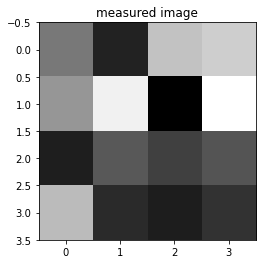

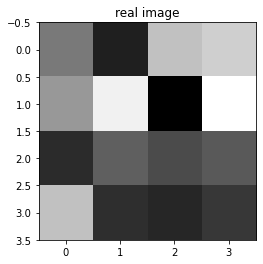

In [8]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)